# Modifications

Link to Interactive Notebook: 
https://colab.research.google.com/drive/1sbJTsgCsAQwCkGdLXK7EdgkaTpiTGBM1#scrollTo=T71qxHyh9p23

1. Reduced Input Dimension
2. Different handling of xco2
3. Custom rmse function

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-10-21 09:59:45.254790: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)



/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Data Preprocessing

In [3]:
def convert_nan(arr):
    """
    convert_nan(arr)
    - converts nan values to the lowest value (continents)
    """
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val-1
    return arr

def add_dimension(arr):
    """
    add_dimension(arr)
    - add one dimension to axis=3
    """
    images=np.expand_dims(arr, axis=3)
    return images

def scale_image(arr):
    """
    scale_image(arr)
    - scales numerical values from scale 0-255 for like an image
    - have tried, regular normal/ min-max scaler -> does not work well
    """
    ## Normal
    #arr=(arr-np.mean(arr))/np.std(arr)
    
    ## Min-Max
    # min_val=arr.min()
    # max_val=arr.max()
    # arr=arr/(min_val-max_val)

    ## Image Scale
    min_pixel = arr.min() 
    max_pixel = arr.max()
    new_min = 0
    new_max = 255
    arr = (arr-min_pixel)*(255)/(max_pixel-min_pixel)+new_min 
    return arr
  

def preprocess_image_reduced(data,xco2=False):
  """
  preprocess_image_reduced(data,xco2=False)
  wrapper function for image preprocessing process
  dimension reduced the output should be  (180,360,5)
  """
  if xco2:
    return data
  return scale_image(convert_nan(data))

In [4]:
## XCO2 Handling
# - xco2 values are a constant value across the globe, 
# - creating an image layer with constant value for the model
# - xco2 layer improves prediction

xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)

chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)

# need to preprocess pco2_image otherwise, the prediction does not work well
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

# stacks image layer
X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

340.84854 407.2084

xco2 shape: 
(421, 180, 360) (421, 180, 360)


In [5]:
# transform shapes to 421,180,360,5 | kernel = 5
X=X.reshape((421,180,360,5))
X.shape

(421, 180, 360, 5)

In [6]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

## Modeling

### Image Segmentation
CNN - Unet

Reference: 
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [7]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    #y_pred = y_pred[y_true != 0]
    #y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

### Base Model

In [43]:
tf.keras.backend.clear_session()

In [44]:
def simple_unet(pretrained_weights = None,input_size = INPUT_SHAPE, output_size=OUTPUT_SHAPE):
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(inputs)
    conv1 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(conv1)
    drop1 = keras.layers.Dropout(0.3)(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=3)(drop1)
    
    conv3 = keras.layers.Conv2D(128, 5, activation = 'elu', padding = 'same')(pool1)
    conv3 = keras.layers.Conv2D(128, 5, activation = 'elu', padding = 'same')(conv3)
    drop3 = keras.layers.Dropout(0.3)(conv3)

    up9 = keras.layers.Conv2D(64, 4, activation = 'elu', padding = 'same')(keras.layers.UpSampling2D(size = 3)(drop3))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(merge9)
    conv9 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(conv9)
    conv9 = keras.layers.Conv2D(2, 5, activation = 'elu', padding = 'same')(conv9)
    conv10 = keras.layers.Conv2D(1, 1, activation = 'elu')(conv9)
    outputs = keras.layers.Reshape(output_size)(conv10)

    model = keras.Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = "nadam", loss = custom_rmse, metrics = ["mean_squared_error"])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

def classic_unet(pretrained_weights = None,input_size = INPUT_SHAPE, output_size=OUTPUT_SHAPE):
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(inputs)
    conv1 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(128, 5, activation = 'elu', padding = 'same')(pool1)
    conv2 = keras.layers.Conv2D(128, 5, activation = 'elu', padding = 'same')(conv2)
    drop1 = keras.layers.Dropout(0.5)(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

    conv3 = keras.layers.Conv2D(256, 5, activation = 'elu', padding = 'same')(pool2)
    conv3 = keras.layers.Conv2D(256, 5, activation = 'elu', padding = 'same')(conv3)
    drop3 = keras.layers.Dropout(0.5)(conv3)

    up8 = keras.layers.Conv2D(128, 4, activation = 'elu', padding = 'same')(keras.layers.UpSampling2D(size = (2,2))(drop3))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(128, 5, activation = 'elu', padding = 'same')(merge8)
    conv8 = keras.layers.Conv2D(128, 5, activation = 'elu', padding = 'same')(conv8)

    up9 = keras.layers.Conv2D(64, 4, activation = 'elu', padding = 'same')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(merge9)
    conv9 = keras.layers.Conv2D(64, 5, activation = 'elu', padding = 'same')(conv9)
    conv9 = keras.layers.Conv2D(2, 5, activation = 'elu', padding = 'same')(conv9)
    conv10 = keras.layers.Conv2D(1, 1, activation = 'elu')(conv9)
    outputs = keras.layers.Reshape(output_size)(conv10)

    model = keras.Model(inputs = inputs, outputs = outputs)

    model.compile(optimizer = "nadam", loss = custom_rmse, metrics = ["mean_squared_error"])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [45]:
unet_model = simple_unet(input_size=INPUT_SHAPE, output_size=OUTPUT_SHAPE)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 360, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 180, 360, 64) 8064        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 180, 360, 64) 102464      conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 180, 360, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [46]:
model_path="../models/base_model/unet_model1.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]


history =unet_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)



Epoch 1/100
27/27 [==============================] - 10s 340ms/step - loss: 98.8585 - mean_squared_error: 39055.4962 - val_loss: 55.3897 - val_mean_squared_error: 3558.4312
Epoch 2/100
27/27 [==============================] - 9s 318ms/step - loss: 36.4648 - mean_squared_error: 1549.4597 - val_loss: 48.6136 - val_mean_squared_error: 2702.5635
Epoch 3/100
27/27 [==============================] - 9s 319ms/step - loss: 34.0475 - mean_squared_error: 1365.6455 - val_loss: 50.2782 - val_mean_squared_error: 2883.0579
Epoch 4/100
27/27 [==============================] - 9s 320ms/step - loss: 32.1189 - mean_squared_error: 1217.2066 - val_loss: 57.1488 - val_mean_squared_error: 3784.3894
Epoch 5/100
27/27 [==============================] - 9s 321ms/step - loss: 30.1026 - mean_squared_error: 1081.3425 - val_loss: 57.5756 - val_mean_squared_error: 3826.0222
Epoch 6/100
27/27 [==============================] - 9s 321ms/step - loss: 26.2453 - mean_squared_error: 821.5645 - val_loss: 56.9161 - val_mea

### UNET Model Output

In [32]:

best_model = tf.keras.models.load_model("../models/base_model/unet_model1.h5", custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 1s 638ms/step


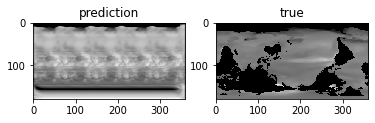

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('base_model_prediction.png')

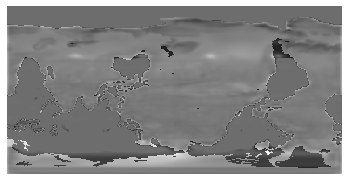

In [39]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

## Testing Generalization Capability

Using Validation data of other dataset

In [28]:
val_dir_name="../data/data2"

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(val_dir_name)

In [ ]:
xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)


chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)

X=X.reshape((421,180,360,5))
X.shape


In [ ]:
predicted_image=best_model.predict(X,verbose=1)

In [ ]:
figure, axis = plt.subplots(1, 2)

axis[0].imshow(np.squeeze(predicted_image[0]), cmap="gray", interpolation="nearest")
axis[0].set_title("val_prediction")
axis[1].imshow(np.squeeze(pco2_images[0]), cmap="gray", interpolation="nearest")
axis[1].set_title("val_true")

plt.show()

In [ ]:
# generalization works pretty well

## Getting PCO2 Prediction per Point

In [ ]:
def inverse_scale_image(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    old_min = np.min(df)
    old_max = np.max(df)
    output = arr*(old_max-old_min)/255 + old_min
    return output

def get_point_prediction(pred,lon,lan):
    pco2_value = pred[lon:lan]
    return pco2_value
    